## Inicjalizacja środowiska programistycznego

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Komórki rekurencyjne - jednostki w których wartość wyjściowa jest podawana z powrotem na wejście. 
Wartości wyjściowe i wejściowe są obliczane w krokach "czasowych".
Wyjście z poprzedniego kroku, `i-1`, jest podawane na wejście w aktualnym kroku, `i`:

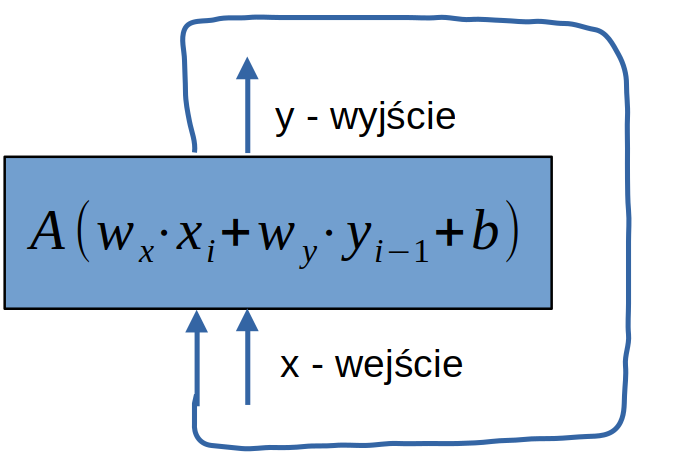

Stan neuronu w kroku `i` jest nazywany zwykle stanem ukrytym, `ang. hidden` i nie musi być on tożsamy z wartością wyjściową neuronu.
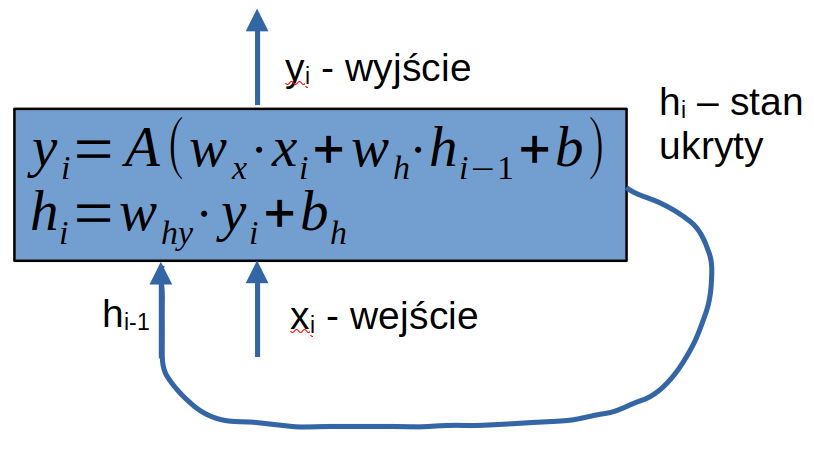

Standardowo komórki RNN przetwarzają sekwencje: 

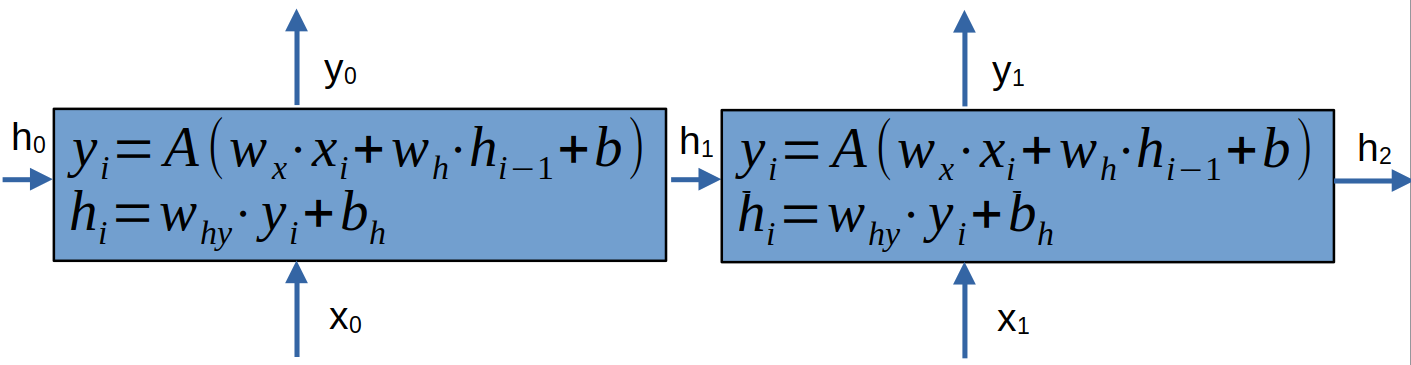

Warstwa zawierająca najprostszy wariant, **bez dodatkowego mieszania składowych stanu ukrytego,**  komórki rekurencyjnej, ang. `Recurrent Neural Network cell, RNN cell` 
jest zaimplementowana w interfejsie użytkownika Keras jako

```Python
tf.keras.layers.SimpleRNN(
    units,                              # liczba neuronów
    activation='tanh',                  # funkcja aktywacji. W RNN zwykle używa się tanh(x)
    use_bias=True,                      # czy wartwa ma używać wyrazów wolnegych?
    recurrent_initializer='orthogonal', # inicjalizacja wag mieszających składowe stanu ukrytego
    recurrent_regularizer=None,         # regularyzacja wag mieszających składowe stanu ukrytego
    dropout=0.0,                        # ułamek losowo zerowanych składowych danych wejściowych
    recurrent_dropout=0.0,              # ułamek losowo zerowanych skłądowych stanu ukrytego
    return_sequences=False,             # czy warstwa ma zwracać sekwencję wartości w kolejnych krokach?
    return_state=False,                 # czy warstwa ma zwracać stan ukryty?
    go_backwards=False,                 # czy warstwa ma przetwarzać sekwencję w odwrotnej kolejności?
)
```

In [2]:
batchSize = 1
nTimeSteps = 3
inputDimension = 2
outputDimension = 2

input = np.random.random((batchSize, nTimeSteps, inputDimension))
simple_rnn = tf.keras.layers.SimpleRNN(outputDimension)
output = simple_rnn(input)  
print(colored("RNN cell output:","blue"), output)

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       return_sequences=True, 
                                       return_state=True)
output = simple_rnn(input)  
print(colored("RNN cell output:","blue"), output)

RNN cell output: tf.Tensor([[0.8522654  0.36667973]], shape=(1, 2), dtype=float32)
RNN cell output: (<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[ 0.34040168,  0.51028055],
        [ 0.47038078, -0.26833642],
        [ 0.47716105,  0.06388897]]], dtype=float32)>, <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.47716105, 0.06388897]], dtype=float32)>)


Badanie działania komórki RNN.

**Proszę:**

* przygotować dane wejściowe dla warstwy RNN: 
    * jedna paczka
    * sto kroków czasowych
    * kolejne liczby całkowite w każdym kroku: `(0)`, `(1)` itd.

 * wypisać na ekran dane dla pierwszych pięciu kroków i ich kształt. 
 * sprawdzić czy kształt jest poprawny: `(batchSize, nSteps, inputDim)`   

In [3]:
#BEGIN_SOLUTION
batchSize = 1
nTimeSteps = 100
inputDim = 1
input = np.arange(0, nTimeSteps, 1).reshape(batchSize, nTimeSteps, inputDim)

print(colored("Input:","blue"), input[:,0:5,:])
print(colored("Input shape:","blue"), input.shape)
#END_SOLUTION
pass

Input: [[[0]
  [1]
  [2]
  [3]
  [4]]]
Input shape: (1, 100, 1)




**Proszę:**

* zaicjializować wagi tak by komórka RNN zwracała sumę elementów w sekwencji

**Wskazówki:**
* użyć funkcji `customInitializer(kernel_matrix)` do inicjializacji wag
* uwaga na funkcję aktywacji


In [4]:
try: 
    class customInitializer(tf.keras.Initializer):
        def __init__(self, kernel):
            self.kernel = kernel

        def __call__(self, shape, dtype=None, **kwargs):
            x = tf.reshape(self.kernel, shape)
            x= tf.cast(x, dtype)
            return x  
except AttributeError:
    print(colored("tf.keras.Initializer not available","red"))
    print(colored("TF version:","blue"),tf.__version__)
    pass

In [20]:
#BEGIN_SOLUTION
inputDimension = 1
kernel_matrix = np.diag([1])
recurrent_kernel_matrix = np.diag([1])

simple_rnn = tf.keras.layers.SimpleRNN(inputDimension,
                                       activation='linear',
                                       kernel_initializer=customInitializer(kernel_matrix),
                                       recurrent_initializer=customInitializer(recurrent_kernel_matrix),
                                       #return_sequences=True, 
                                       #return_state=True
                                       )

output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
print(colored("input:","blue"), input[:,0:5,:])
print(colored("RNN cell output:","blue"), output[:,0:5])
print(colored("Sequence sum:","blue"), np.sum(input, axis=1))
#END_SOLUTION
pass


input: [[[55]
  [89]]]
RNN cell output: tf.Tensor([[144.]], shape=(1, 1), dtype=float32)
Sequence sum: [[144]]


**Proszę:**

* użyć komórki RNN do generacji liczb z ciągu Fibonacciego:
$$
\huge{
F_{n} = F_{n-1} + F_{n-2}, F_{0} = 0, F_{1} = 1
}
$$

**Wskazówka:**
* komórka powinna przyjmować ciąg dwu poprzednich elementów
* generacja kolejnych elementów powinna się odbywać w pętli
* można użyć funkcji `np.roll(...)` 


In [21]:
#BEGIN_SOLUTION
nTimeSteps = 2
input = np.array([0,1]).reshape(batchSize, nTimeSteps, inputDim)

for i in range(0,10):
    output = simple_rnn(input, initial_state= tf.constant([[0]], dtype=tf.float64))
    input = np.roll(input, 1, axis=1)
    input[:,-1,:] = output[0,0]
    print(colored("Fibnacci numer:","blue"), output[0,0].numpy())
#END_SOLUTION
pass    


Fibnacci numer: 1.0
Fibnacci numer: 2.0
Fibnacci numer: 3.0
Fibnacci numer: 5.0
Fibnacci numer: 8.0
Fibnacci numer: 13.0
Fibnacci numer: 21.0
Fibnacci numer: 34.0
Fibnacci numer: 55.0
Fibnacci numer: 89.0


**Proszę:**

* napisać funkcję `generateFibonacci(n)` która generuje pierwszych `n` elementów ciągu Fibonacciego:
* stworzyć macierz `fib_sequence` zawierającą pierwsze `30` elementów ciągu Fibonacciego - zaczynając od `[1,1,...]`
* podzielić listę na fragmenty o długości `window_size=6` używając ruchomego okna z krokiem `1`.
* wypisać na ekran oryginalną i podzieloną listę

**Wskazówka:**

* do podziału listy na fragmenty można użyć funkcji `tf_text.sliding_window`

In [24]:
#BEGIN_SOLUTION
fib = [1, 1]

def generateFibonacci(n=30):
    while len(fib) < n:
        fib.append(fib[-1] + fib[-2])
        yield fib[-1]

fib_sequence = np.array([x for x in generateFibonacci()])

window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

print(colored("Fibonacci sequence:","blue"), fib)
print(colored("Fibonacci sequence split into windows:","blue"), slidingWindowWithWidth(fib))
#END_SOLUTION
pass

Fibonacci sequence: [1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368, 75025, 121393, 196418, 317811, 514229, 832040]
Fibonacci sequence split into windows: tf.Tensor(
[[     1      1      2      3      5      8]
 [     1      2      3      5      8     13]
 [     2      3      5      8     13     21]
 [     3      5      8     13     21     34]
 [     5      8     13     21     34     55]
 [     8     13     21     34     55     89]
 [    13     21     34     55     89    144]
 [    21     34     55     89    144    233]
 [    34     55     89    144    233    377]
 [    55     89    144    233    377    610]
 [    89    144    233    377    610    987]
 [   144    233    377    610    987   1597]
 [   233    377    610    987   1597   2584]
 [   377    610    987   1597   2584   4181]
 [   610    987   1597   2584   4181   6765]
 [   987   1597   2584   4181   6765  10946]
 [  1597   2584   4181   6765  10946  17711]
 [

**Proszę:**

* stworzyć obiekt `tf.data.Dataset` którego elementami są `szóstki` kolejnych elementów ciągu Fibonacciego
* przetworzyć wiersze w danych do postaci `(features, label)`  gdzie  `label` to ostatni element grupy, a `features` to pozostałe
* zadbać by cechy miały kształt oczekiwany przez warstwy rekurencyjne: `(nSteps, inputDim)`
* wypisać na ekran pierwsze cztery wiersze danych

In [37]:
#BEGIN_SOLUTION
inputDim = 1

window_size = 6
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)

dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(fib))
dataset = dataset.map(lambda x: tf.reshape(x, (window_size, inputDim))).map(lambda y: (y[:-1,:], y[-1,0])).batch(5).cache()  
 
for item in dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]) 
#END_SOLUTION
pass   

Features: [1 1 2 3 5] Labels: 8
Features: [ 8 13 21 34 55] Labels: 89
Features: [ 89 144 233 377 610] Labels: 987
Features: [ 987 1597 2584 4181 6765] Labels: 10946


2024-05-20 15:16:30.708510: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-20 15:16:30.708742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model sekwencyjny z komórkami RNN:
```Python
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),  # kształt danych wejściowych: (liczba kroków, wymiar danych w kroku
        tf.keras.layers.SimpleRNN(nUnits)                                           # liczba kroków nie jest znana z góry, dlatego dajemy None
model.summary()
```

In [38]:
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
                                      tf.keras.layers.SimpleRNN(1)])  
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_16 (SimpleRNN)       │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

**Proszę:**

* zbudować i wytrenować model z komórką `SimpleRNN` który przewidzi następny element ciągu Fibonacciego na podstawie podanego ciągu - niekoniecznie dwuelementowego

**Wskazówki:**
* jak funkcja aktywacji jest odpowiednia dla wyjścia o wartości nieograniczonej z góry?
* trening może być niestabilny - trzeba go przeprowadzić kilkakrotnie

Epoch 544: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 0.1360


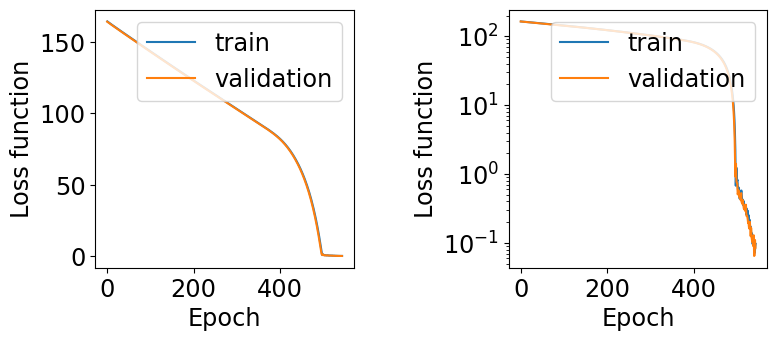

In [49]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.SimpleRNN(1, activation='linear',  
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
                            )],
                            name="fib_generator")  
#model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*200,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mape', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,   
                                                       patience=3, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset,
                    validation_data=dataset,
                    callbacks=callbacks,
                    epochs=1500, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass  

**Proszę:**

* podać na wejście modelu ciąg 
```
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
```
* podać ten sam ciąg, **pomijając pierwszy element**
* podać dwa ostatnie elementy ciągu
* we wszystkich przypadkach porównać wynik modelu z wartością oczekiwaną dla elementów ciągu Fibbonaciego

In [50]:
#BEGIN_SOLUTION
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
print(colored("Data:","blue"), data[0,:,0])
print(colored("Prediction:","blue"),model.predict(data)[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,1:,0])
print(colored("Prediction:","blue"),model.predict(data[:,1:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,-2:,0])
print(colored("Prediction:","blue"),model.predict(data[:,-2:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])
#END_SOLUTION
pass

Data: [ 46368  75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Prediction: 836496.9 True value: 832040
Data: [ 75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Prediction: 831726.06 True value: 832040
Data: [317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: 709997.2 True value: 832040


Komórka RNN ma pewną wadę: wyjście jest średnią ważoną wejścia i stanu z poprzedniego kroku. To oznacza, że dane z odległych kroków w przeszłości mają mały wpływ na stan komórki w bieżącym kroku - komórka ma jedynie pamięć krótkotrwałą. Rozwiązaniem tego problemu jest wyposażenie komórki w dodatkowy stan ukryty, który może przechowywać dane w długim kresie czasu - pamięć długotrwałą. Komórka ma więc dwa rodzaje pamięci - krótko- i długo-trwałą, ang. `Long Short-Term Memory, LSTM`.




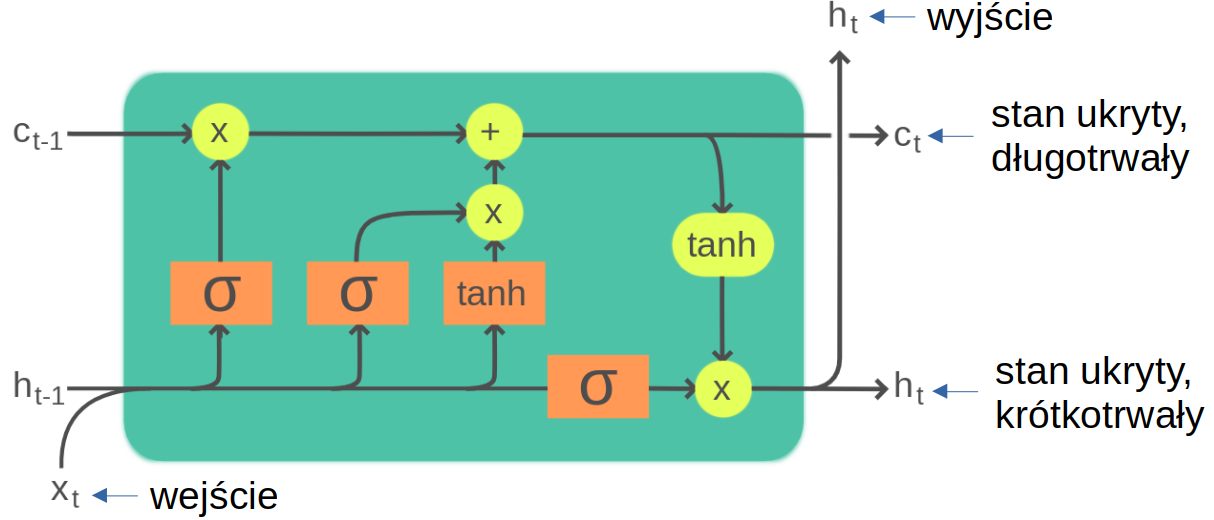

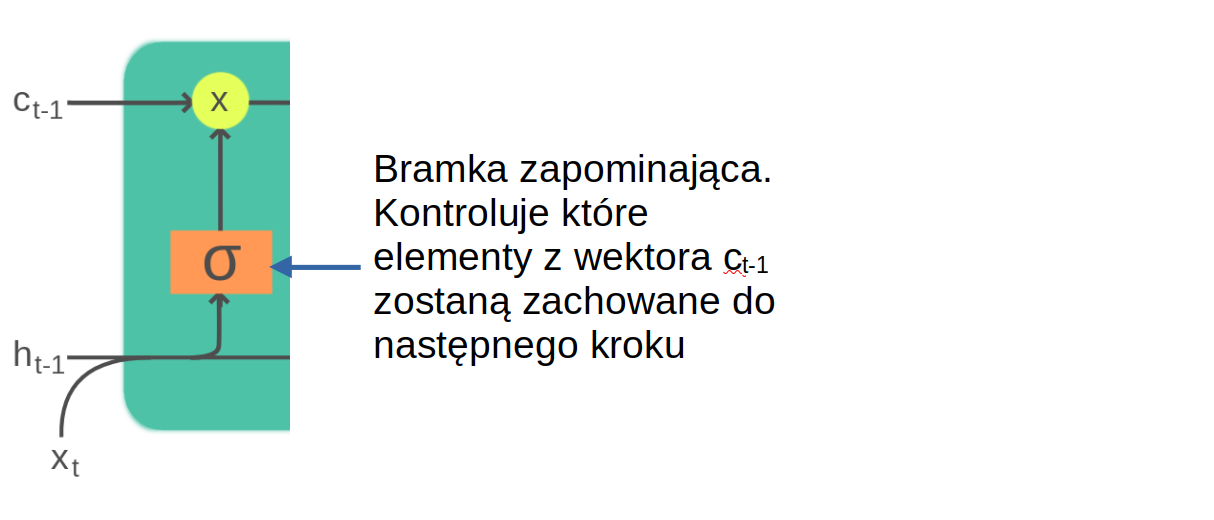

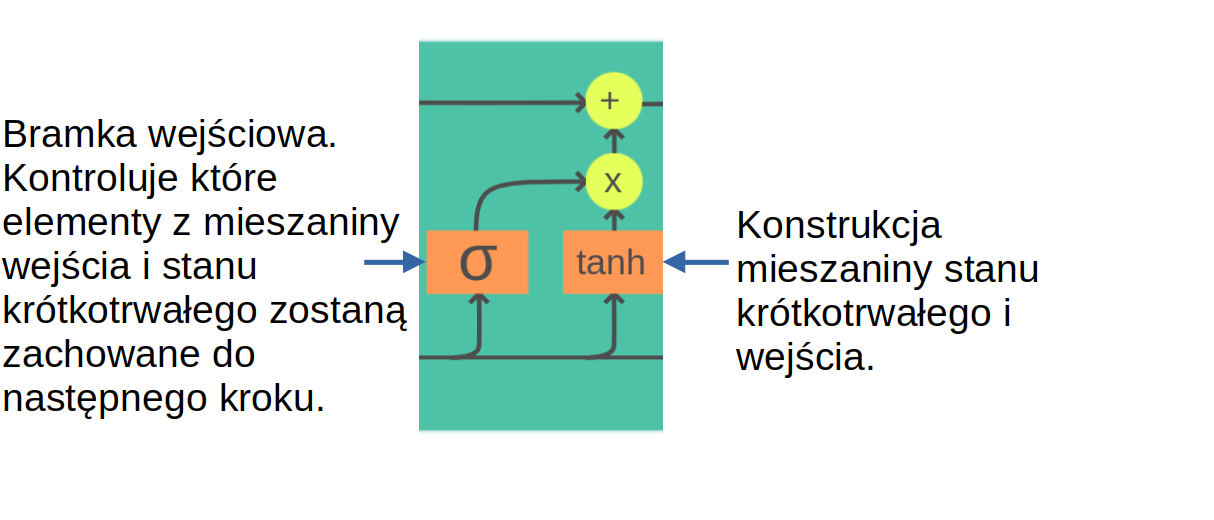

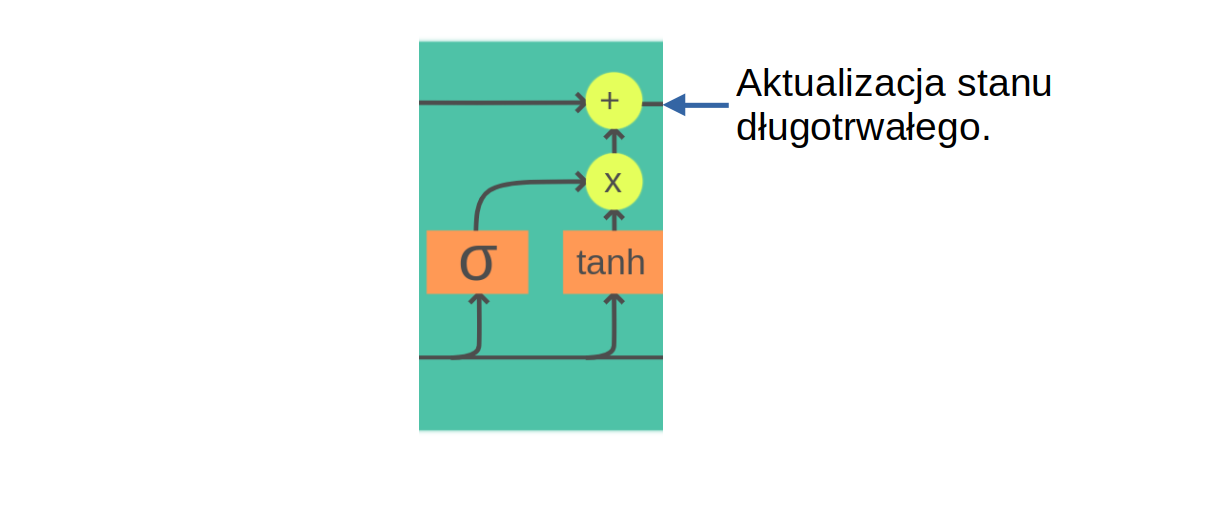

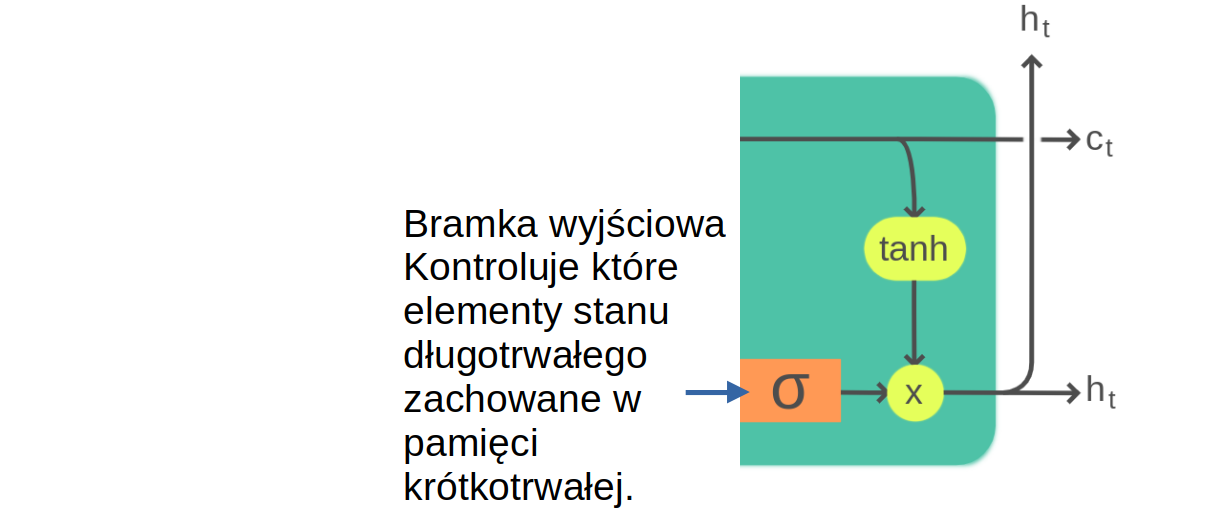

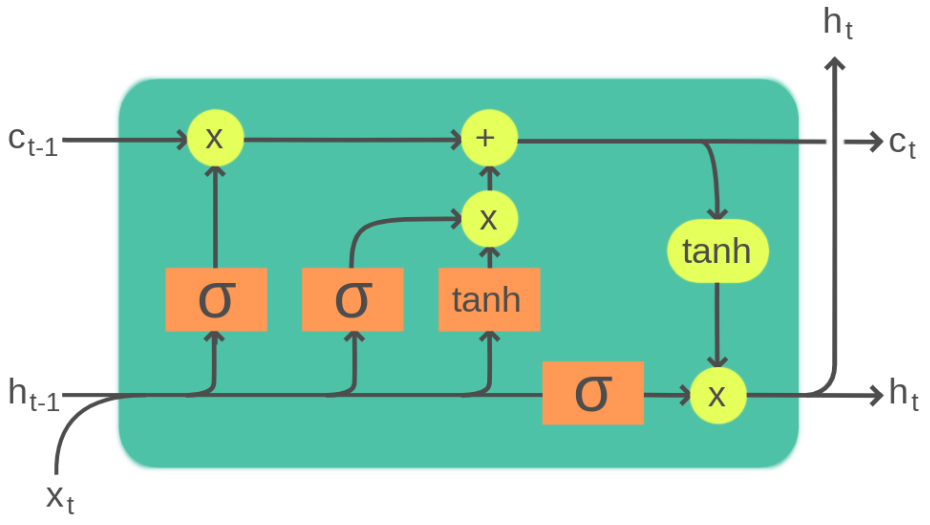

Implementacja komórki LSTM w Keras:
```Python
tf.keras.layers.LSTMCell(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    seed=None,
    **kwargs
)
```

**Proszę:**

* zbudować i wytrenować model z komórką RSTM który przewidzi następny element ciągu Fibonacciego na podstawie podanego ciągu - niekoniecznie dwuelementowego

**Wskazówki:**
* jak funkcja aktywacji jest odpowiednia dla wyjścia o wartości nieograniczonej z góry?
* trening jest niestabilny - trzeba go przeprowadzić kilkakrotnie

Epoch 196: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.2539


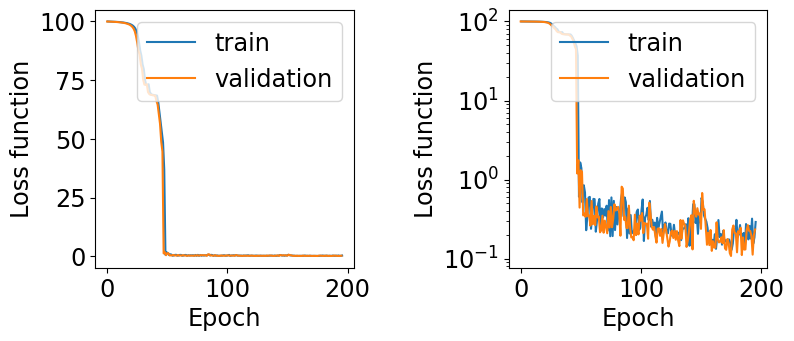

In [102]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation='linear',  
                            bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
                            )],
                            name="fib_generator")  
#model.summary()

initial_learning_rate = 5E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*100,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mape', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,   
                                                       patience=20, verbose=1)
callbacks = [early_stop_callback]

history = model.fit(dataset,
                    validation_data=dataset,
                    callbacks=callbacks,
                    epochs=500, verbose=0)
model.evaluate(dataset)
plf.plotTrainHistory(history)
#END_SOLUTION
pass  

**Proszę:**

* wypisać na ekran etykiety i efekt działania modelu
* narysować panel z dwoma rysunkami:
   * X=model,  Y=etykieta
   * X=numer elementu, Y=model/etykieta

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
Label, prediction: 8 8
Label, prediction: 13 13
Label, prediction: 21 21
Label, prediction: 34 34
Label, prediction: 55 55
Label, prediction: 89 88
Label, prediction: 144 143
Label, prediction: 233 232
Label, prediction: 377 377
Label, prediction: 610 611
Label, prediction: 987 989
Label, prediction: 1597 1601
Label, prediction: 2584 2590
Label, prediction: 4181 4190
Label, prediction: 6765 6780
Label, prediction: 10946 10970
Label, prediction: 17711 17750
Label, prediction: 28657 28720
Label, prediction: 46368 46471
Label, prediction: 75025 75191
Label, prediction: 121393 121661
Label, prediction: 196418 196852
Label, prediction: 317811 318514
Label, prediction: 514229 515366
Label, prediction: 832040 833879


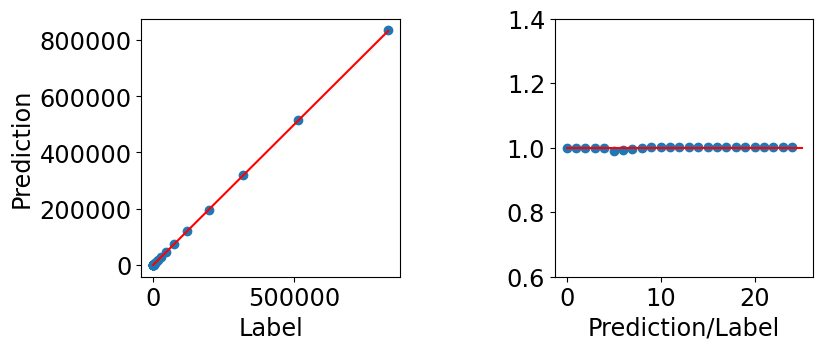

In [103]:
#BEGIN_SOLUTION
predictions = model.predict(dataset)[:,0].astype(int)
labels = fib_sequence[window_size-3:]

for label, prediction in zip(labels, predictions):
    print(colored("Label, prediction:","blue"), label, prediction)

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes[0].plot(labels, predictions, 'o')
axes[0].plot([0,max(labels)], [0,max(labels)], 'r')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Prediction")

axes[1].plot(predictions/labels, 'o')
axes[1].plot([0,len(labels)], [1,1], 'r')
axes[1].set_xlabel("Prediction/Label")
axes[1].set_ylim([0.6,1.4])
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)
#END_SOLUTION
pass

**Proszę:**

* podać na wejście modelu ciąg 
```
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
```
* podać ten sam ciąg, **pomijając pierwszy element**
* podać dwa ostatnie elementy ciągu
* we wszystkich przypadkach porównać wynik modelu z wartością oczekiwaną dla elementów ciągu Fibbonaciego

In [104]:
#BEGIN_SOLUTION
data = np.array([[[46368], [75025], [121393], [196418], [317811], [514229]]])
print(colored("Data:","blue"), data[0,:,0])
print(colored("Prediction:","blue"),model.predict(data)[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,1:,0])
print(colored("Prediction:","blue"),model.predict(data[:,1:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])

print(colored("Data:","blue"), data[0,-2:,0])
print(colored("Prediction:","blue"),model.predict(data[:,-2:,:])[0,0], end=" ")
print(colored("True value:","blue"),data[0,-1,0]+data[0,-2,0])
#END_SOLUTION
pass

Data: [ 46368  75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Prediction: 848041.4 True value: 832040
Data: [ 75025 121393 196418 317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Prediction: 833879.75 True value: 832040
Data: [317811 514229]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Prediction: 641498.4 True value: 832040


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184


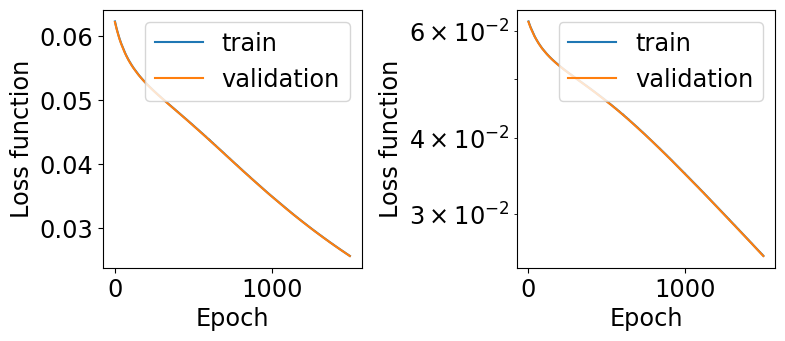

In [68]:
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, 1)),
    tf.keras.layers.LSTM(1, activation="sigmoid",
                         bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1))],
                         name="fib_generator")  
#model.summary()

initial_learning_rate = 1E-3
nStepsPerEpoch = dataset.cardinality().numpy()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*200,
                decay_rate=0.95,
                staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='mse', metrics=[])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       start_from_epoch=15,   
                                                       patience=5, verbose=1)
callbacks = [early_stop_callback]

scale = fib_sequence.max()
dataset_scaled = dataset.map(lambda x, y: (float(x)/scale, float(y)/scale))
history = model.fit(dataset_scaled.shuffle(100),
                    validation_data=dataset_scaled,
                    callbacks=callbacks,
                    epochs=1500, verbose=0)
model.evaluate(dataset_scaled)
plf.plotTrainHistory(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Label, prediction: 8 103195
Label, prediction: 13 103196
Label, prediction: 21 103198
Label, prediction: 34 103201
Label, prediction: 55 103205
Label, prediction: 89 103213
Label, prediction: 144 103224
Label, prediction: 233 103243
Label, prediction: 377 103274
Label, prediction: 610 103324
Label, prediction: 987 103405
Label, prediction: 1597 103536
Label, prediction: 2584 103748
Label, prediction: 4181 104092
Label, prediction: 6765 104651
Label, prediction: 10946 105560
Label, prediction: 17711 107047
Label, prediction: 28657 109493
Label, prediction: 46368 113556
Label, prediction: 75025 120409
Label, prediction: 121393 132245
Label, prediction: 196418 153387
Label, prediction: 317811 192789
Label, prediction: 514229 268694
Label, prediction: 832040 409422


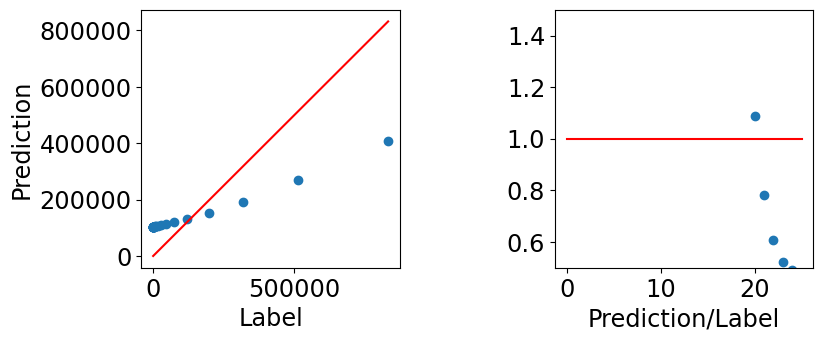

In [69]:
predictions = (model.predict(dataset_scaled)[:,0]*scale).astype(int)
labels = fib_sequence[window_size-3:]

for label, prediction in zip(labels, predictions):
    print(colored("Label, prediction:","blue"), label, prediction)

fig, axes = plt.subplots(1, 2, figsize=(7,3))

axes[0].plot(labels, predictions, 'o')
axes[0].plot([0,max(labels)], [0,max(labels)], 'r')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Prediction")

axes[1].plot(predictions/labels, 'o')
axes[1].plot([0,len(labels)], [1,1], 'r')
axes[1].set_xlabel("Prediction/Label")
axes[1].set_ylim([0.5,1.5])
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.6)

# Zadanie domowe

**Proszę:**


